# Function approximation with linear models and neural network
* Are Linear models sufficient for approximating transcedental functions? What about polynomial functions?
* Do neural networks perform better in those cases?
* Does the depth of the neural network matter?

### Import basic libraries

In [2]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            #print('EarlyStopping counter: '+str(self.counter)+' out of '+str(self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print('Validation loss decreased ('+str(self.val_loss_min)+' --> '+str(val_loss)+'.  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint_E.pt')
        self.val_loss_min = val_loss


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset

# Load my data

In [16]:
#name of datafile in same direcory as notebook
#source = '/home/oleksandra/molsim/Holger/Data_collection/Hardness_Elasticity_EDX_combo_new.csv';
source = '/media/sasha/MyBook/oleksandra_home/molsim/Holger/Data_collection/Hardness_Elasticity_EDX_combo_new.csv'
# keys: first row of datafile, property grouping 
pos_keys = ['x', 'y'];
prop_keys = ['E', 'H'];
comp_keys = ['C', 'Ca', 'F', 'Fe', 'Mg', 'Na', 'O', 'P'];
of_interest = prop_keys+comp_keys

In [17]:
species_list = ["AAl", "HCh", "HIs", "HNy", "HSa"]

### Import scikit-learn librares and prepare train/test splits

In [18]:
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LassoCV
# from sklearn.linear_model import RidgeCV
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import make_pipeline

In [19]:
data_all = np.genfromtxt(source, delimiter=',', skip_header=1, dtype=float, usecols=(range(5,15)))

In [20]:
Y_H_ = data_all[:,0]
Y_E_ = data_all[:,1]
X_ = data_all[:,2:]
mean_H = np.mean(Y_H_)
var_H = np.std(Y_H_)
mean_E = np.mean(Y_E_)
var_E = np.std(Y_E_)
Y_H = (Y_H_- mean_H)/var_H
Y_E = (Y_E_- mean_E)/var_E
mean_X = np.mean(X_,axis=0)
var_X = np.std(X_,axis=0)
X = (X_- mean_X)/var_X

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_E, test_size=0.20)

#X_train=X_train.reshape(X_train.size,1)
#y_tr_l = np.copy(y_train)
y_train=y_train.reshape(y_train.size,1)

#X_test=X_test.reshape(X_test.size,1)
y_test=y_test.reshape(y_test.size,1)
#y_test_l = np.copy(y_test)

# from sklearn import preprocessing
# X_scaled = preprocessing.scale(X_train)
# y_scaled = preprocessing.scale(y_train)

In [22]:
X_train.shape

(1040, 8)

In [56]:
def predict_all_tooth(data_path, comp_keys, Y_H, model):
    #read all data
    read_data = []
    for c in comp_keys:
        data = np.genfromtxt(data_path+"/"+str(c)+".txt" )
        size = data.shape
        #print size

        read_data.append(data.ravel())
    read_data = np.array(read_data).T
    
    data_mask = np.zeros(read_data.shape[0])
    read_data_new = []
    for i in range(len(read_data)):
        if len(np.where(read_data[i] > 0.)[0]) > 3:
            read_data_new.append(read_data[i])
            data_mask[i] = 1
            
    read_data_new = (np.array(read_data_new) - mean_X)/var_X
    
    # Add ops to save and restore all the variables.
    
#     tf.reset_default_graph()
#     (x, y_), _, accuracy, y, saver = build_graph(is_training=False)

#     # Later, launch the model, use the saver to restore variables from disk, and
#     # do some work with the model.
#     with tf.Session() as sess:
#       # Restore variables from disk.
#         sess.run(tf.global_variables_initializer())
#         saver.restore(sess, model_name)
#         print("Model restored.")
#         y_pr = sess.run(y,feed_dict={x:read_data_new})

    y_p = model(torch.from_numpy(read_data_new).float())
    
    y_pr = y_p.data.numpy()
        
#     print("Max of training dataset: ", max(Y_H))
#     print("Max of predictions: ", y_pr.max())
        
    rebuilded = np.zeros(read_data.shape[0])
    count = 0
    for i in range(len(data_mask)):
        if data_mask[i] != 0: 
            rebuilded[i] = y_pr[count]
            count += 1  
            
    rebuilded_new = rebuilded.reshape(size)
    
#     print("Number of prediction grater than max of training data: ", len(np.where(rebuilded_new > max(Y_H))[0]))
    
    return rebuilded_new, y_pr

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true)* var_E +mean_E, np.array(y_pred)* var_E +mean_E
    res = []
    for i in range(len(y_true)):
        if y_true[i] != 0.:
            res.append(np.abs((y_true[i] - y_pred[i]) / y_true[i]))
    return np.mean(res) * 100

In [13]:
def get_errors(test_data, predicted_data):
    # Total variance
    SSt_DNN = np.sum(np.square(test_data-np.mean(test_data)))
    # Residual sum of squares
    SSr_DNN = np.sum(np.square(predicted_data-test_data))
    # Root-mean-square error
    RMSE_DNN = np.sqrt(np.sum(np.square(predicted_data-test_data)))
    # R^2 coefficient
    r2_DNN = 1-(SSr_DNN/SSt_DNN)
    MAPE = mean_absolute_percentage_error(test_data, predicted_data)
    return RMSE_DNN, r2_DNN, MAPE

## Neural network for regression

In [23]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        #self.hidden2 = torch.nn.Linear(n_hidden, 8)   # hidden layer
        #self.hidden_bn = nn.Dropout()
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.tanh(self.hidden(x))      # activation function for hidden layer
        #x = F.relu(self.hidden_bn(self.hidden2(x)))
        #x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x

In [328]:
# https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/301_regression.py
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
matplotlib
"""
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
# y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# torch can only train on Variable, so convert them to Variable
# The code below is deprecated in Pytorch 0.4. Now, autograd directly supports tensors
# x, y = Variable(x), Variable(y)

# plt.scatter(x.data.numpy(), y.data.numpy())
# plt.show()

x = torch.from_numpy(X_train).float()
y = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(X_test).float()
y_val = torch.from_numpy(y_test).float()


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        #self.hidden2 = torch.nn.Linear(n_hidden, 8)   # hidden layer
        #self.hidden_bn = nn.Dropout()
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.tanh(self.hidden(x))      # activation function for hidden layer
        #x = F.relu(self.hidden_bn(self.hidden2(x)))
        #x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x

net = Net(n_feature=8, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture

#optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.SmoothL1Loss()  # this is for regression mean squared loss
optimizer = optim.LBFGS(net.parameters(), lr=0.8)

plt.ion()   # something about plotting

loss_train = []
loss_test = []
#nets = []

avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 
patience = 5
n_epochs = 20
early_stopping = EarlyStopping(patience=patience)
for t in range(n_epochs):
    print('STEP: ', t)
    def closure():
        optimizer.zero_grad()
        out = net(x)
        loss = loss_func(out, y)
        #print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    
    with torch.no_grad():
        prediction = net(x_val)
        loss = loss_func(prediction, y_val)
        pr = net(x)
        loss_tr = loss_func(pr, y)
        loss_train.append(loss_tr.item())
        print('train loss:', loss_tr.item())
        loss_test.append(loss.item())
        print('test loss:', loss.item())
        #prediction = net(x)     # input x and predict based on x

#     loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

#     optimizer.zero_grad()   # clear gradients for next train
#     loss.backward()         # backpropagation, compute gradients
#     optimizer.step()        # apply gradients


#     # print training/validation statistics 
#     # calculate average loss over an epoch
#     train_loss = np.average(train_losses)
#     valid_loss = np.average(valid_losses)
#     avg_train_losses.append(train_loss)
#     avg_valid_losses.append(valid_loss)
        
       
    print("[ "+str(t)+"/"+str(n_epochs)+"] train_loss: "+str(loss_train[t])+ " valid_loss: "+str(loss_test[t]))
        
    # clear lists to track next epoch
#     train_losses = []
#     valid_losses = []
        
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(loss_test[t], net)
        
    if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model



    if t % 1 == 0:
        # plot and show learning process
        plt.cla()
        plt.plot(y_val.data.numpy()[:100])
        plt.plot(prediction.data.numpy()[:100])
        plt.show()
        plt.plot(y.data.numpy()[:200])
        plt.plot(pr.data.numpy()[:200])
        plt.show()
        plt.scatter(y_val.data.numpy(), prediction.data.numpy())
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()

net.load_state_dict(torch.load('checkpoint.pt'))


(0.0, 0.6)

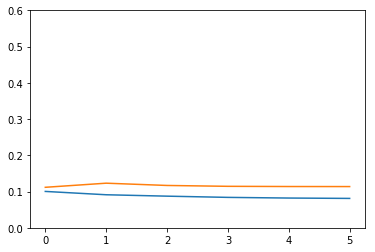

In [320]:
plt.plot(loss_train)
plt.plot(loss_test)
plt.ylim(0., 0.6)

In [321]:
test_data = y_val.data.numpy()
predicted_data = prediction.data.numpy()
get_errors(test_data, predicted_data)

(7.958823, 0.7719187587499619, 28.51352095603943)

In [52]:
def train_and_val(X, Y, n_neurons, test_size =0.2, silent = False):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

    #X_train=X_train.reshape(X_train.size,1)
    #y_tr_l = np.copy(y_train)
    y_train=y_train.reshape(y_train.size,1)

    #X_test=X_test.reshape(X_test.size,1)
    y_test=y_test.reshape(y_test.size,1)
    
    x = torch.from_numpy(X_train).float()
    y = torch.from_numpy(y_train).float()

    x_val = torch.from_numpy(X_test).float()
    y_val = torch.from_numpy(y_test).float()




    net = Net(n_feature=X_train.shape[1], n_hidden=n_neurons, n_output=y_train.shape[1])     # define the network
    if not silent: print(net)  # net architecture

    #optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
    loss_func = torch.nn.SmoothL1Loss()  # this is for regression mean squared loss
    optimizer = optim.LBFGS(net.parameters(), lr=0.8)

    plt.ion()   # something about plotting

    loss_train = []
    loss_test = []
    #nets = []

    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    patience = 5
    n_epochs = 20
    early_stopping = EarlyStopping(patience=patience)
    for t in range(n_epochs):
        if not silent: print('STEP: ', t)
        def closure():
            optimizer.zero_grad()
            out = net(x)
            loss = loss_func(out, y)
            #print('loss:', loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)

        with torch.no_grad():
            prediction = net(x_val)
            loss = loss_func(prediction, y_val)
            pr = net(x)
            loss_tr = loss_func(pr, y)
            loss_train.append(loss_tr.item())
            if not silent: print('train loss:', loss_tr.item())
            loss_test.append(loss.item())
            if not silent: print('test loss:', loss.item())
            #prediction = net(x)     # input x and predict based on x

        if not silent: print("[ "+str(t)+"/"+str(n_epochs)+"] train_loss: "+str(loss_train[t])+ " valid_loss: "+str(loss_test[t]))

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(loss_test[t], net)

        if early_stopping.early_stop:
                if not silent: print("Early stopping")
                break

        

        if t % 1 == 0:
            # plot and show learning process
            if not silent:
                plt.cla()
                plt.plot(y_val.data.numpy()[:100])
                plt.plot(prediction.data.numpy()[:100])
                plt.show()
                plt.plot(y.data.numpy()[:200])
                plt.plot(pr.data.numpy()[:200])
                plt.show()
                plt.scatter(y_val.data.numpy(), prediction.data.numpy())
                plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
                plt.pause(0.1)
    if not silent:
        plt.ioff()
        plt.show()
    
    _, r2, _ = get_errors(y_val.data.numpy(), prediction.data.numpy())
    
    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint_E.pt'))

    l_v = loss_func(net(x_val), y_val).item()
    l_tr = loss_func(net(x), y).item()

    
    return net, r2, l_v, l_tr


Net(
  (hidden): Linear(in_features=8, out_features=20, bias=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
)
('STEP: ', 0)
('train loss:', 0.08470477163791656)
('test loss:', 0.083602175116539)
[ 0/20] train_loss: 0.0847047716379 valid_loss: 0.0836021751165


/home/soft/ANACONDA/Anaconda2-5.0.1/lib/python2.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


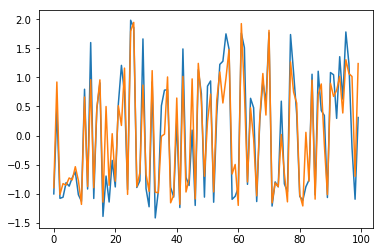

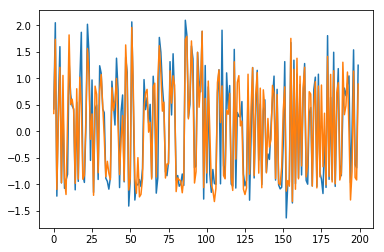

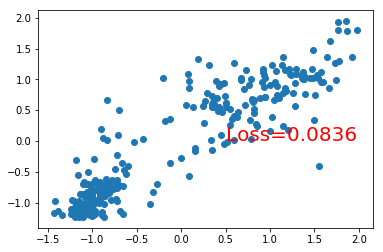

('STEP: ', 1)
('train loss:', 0.07440008223056793)
('test loss:', 0.08489448577165604)
[ 1/20] train_loss: 0.0744000822306 valid_loss: 0.0848944857717
EarlyStopping counter: 1 out of 5


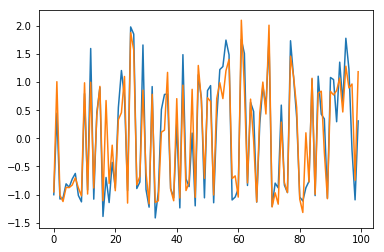

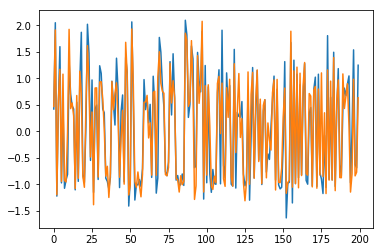

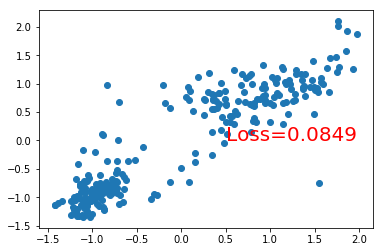

('STEP: ', 2)
('train loss:', 0.06723730266094208)
('test loss:', 0.07719594240188599)
[ 2/20] train_loss: 0.0672373026609 valid_loss: 0.0771959424019


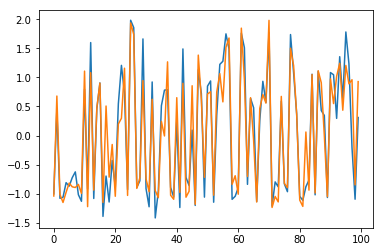

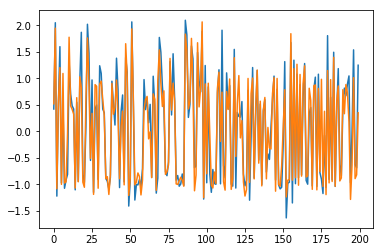

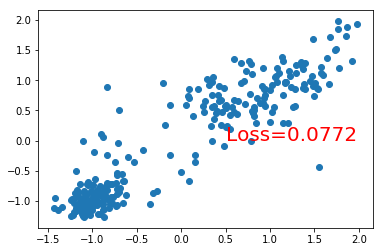

('STEP: ', 3)
('train loss:', 0.06289548426866531)
('test loss:', 0.07707122713327408)
[ 3/20] train_loss: 0.0628954842687 valid_loss: 0.0770712271333


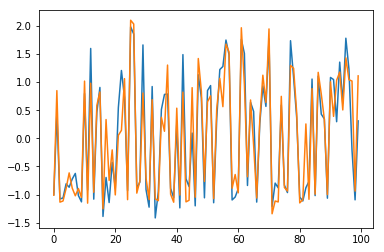

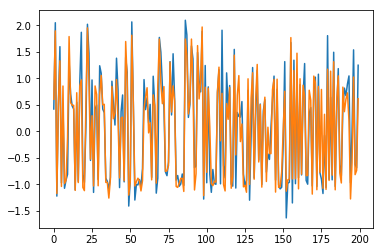

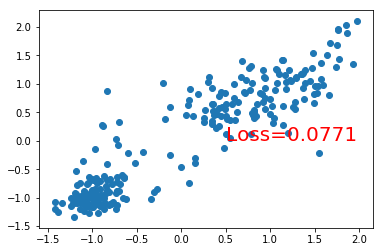

('STEP: ', 4)
('train loss:', 0.057058028876781464)
('test loss:', 0.08337723463773727)
[ 4/20] train_loss: 0.0570580288768 valid_loss: 0.0833772346377
EarlyStopping counter: 1 out of 5


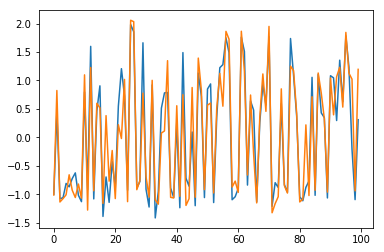

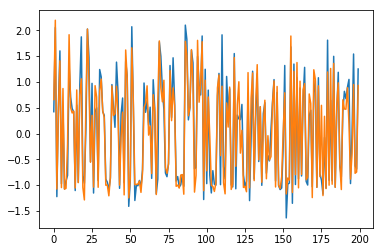

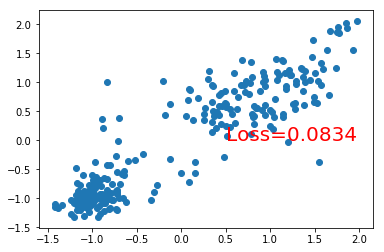

('STEP: ', 5)
('train loss:', 0.053449615836143494)
('test loss:', 0.09082484245300293)
[ 5/20] train_loss: 0.0534496158361 valid_loss: 0.090824842453
EarlyStopping counter: 2 out of 5


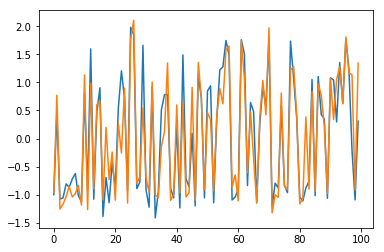

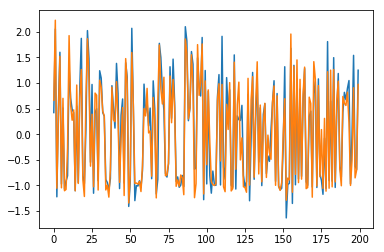

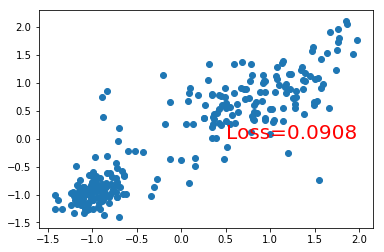

('STEP: ', 6)
('train loss:', 0.0514577217400074)
('test loss:', 0.0962170660495758)
[ 6/20] train_loss: 0.05145772174 valid_loss: 0.0962170660496
EarlyStopping counter: 3 out of 5


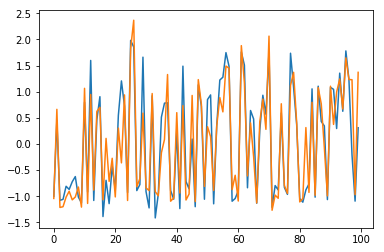

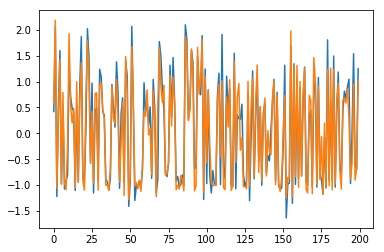

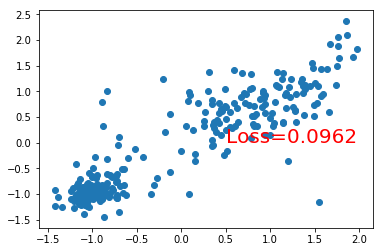

('STEP: ', 7)
('train loss:', 0.049702566117048264)
('test loss:', 0.10004952549934387)
[ 7/20] train_loss: 0.049702566117 valid_loss: 0.100049525499
EarlyStopping counter: 4 out of 5


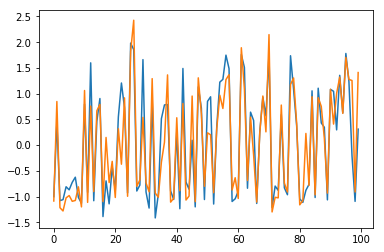

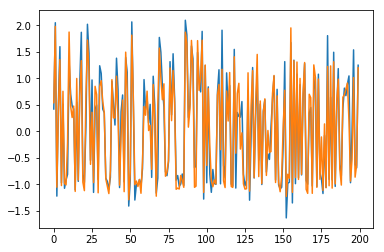

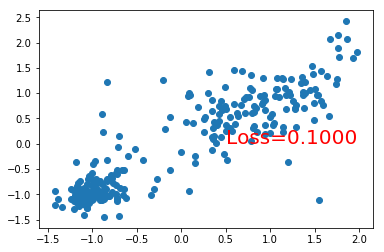

('STEP: ', 8)
('train loss:', 0.04844534024596214)
('test loss:', 0.09979589283466339)
[ 8/20] train_loss: 0.048445340246 valid_loss: 0.0997958928347
EarlyStopping counter: 5 out of 5
Early stopping


In [16]:
net1, R2, loss_v, loss_tr = train_and_val(X, Y_E, 20, test_size =0.2)

In [17]:
print R2, loss_v, loss_tr

0.7814227193593979 0.0770712271333 0.0628954842687


In [376]:
torch.save(net1.state_dict(), "/home/oleksandra/molsim/Holger/Function Approximation by Neural Network/pytorch_NN/net1_H_N_20_R2_77")

In [18]:
print R2, loss_v, loss_tr

0.7814227193593979 0.0770712271333 0.0628954842687


## Predict whole tooth

In [26]:
#data_folder_all = '/home/oleksandra/molsim/Holger/Data_collection/ralf_smooth/'
data_folder_all = '/media/sasha/MyBook/oleksandra_home/molsim/Holger/Data_collection/ralf_smooth/'
AAL_data = data_folder_all+'AAl/'
HCh_data = data_folder_all+'HCh/'
HIs_data = data_folder_all+'HIs/'
HNy_data = data_folder_all+'HNy/'
HSa_data = data_folder_all+'HSa/'

In [27]:
# read all elements and save they in the same order as in input file: C,Ca,F,Fe,Mg,Na,O,P
comp_keys

['C', 'Ca', 'F', 'Fe', 'Mg', 'Na', 'O', 'P']

In [23]:
test_rebuilded_new, pr =  predict_all_tooth(AAL_data, comp_keys, Y_E, net1)
inds = np.where(test_rebuilded_new != 0)
test_rebuilded_new[inds] = test_rebuilded_new[inds]*var_E + mean_E

('Max of training dataset: ', 2.145666357332571)
('Max of predictions: ', 3.1877282)
('Number of prediction grater than max of training data: ', 230)


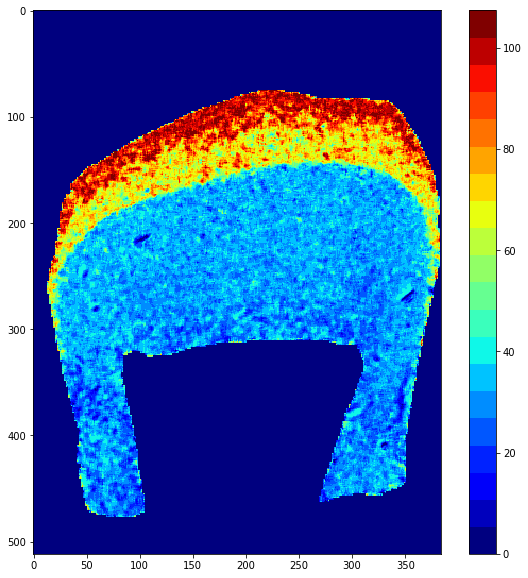

In [24]:
plt.figure(figsize = (10,10))
plt.imshow(test_rebuilded_new, cmap=plt.cm.get_cmap("jet", 20))
plt.clim(0, max(Y_E_))
plt.colorbar()

In [189]:
R_2 = []
nets = []
Loss_v = []
pred = []
for i in range(500):
    print(i)
    net1, R2, loss_v, loss_tr = train_and_val(X, Y_E, 15, test_size =0.2, silent = True)
    R_2.append(R2)
    nets.append(net1)
    Loss_v.append(loss_v)
    test_rebuilded_new, pr =  predict_all_tooth(AAL_data, comp_keys, Y_E, net1)
    inds = np.where(test_rebuilded_new != 0)
    test_rebuilded_new[inds] = test_rebuilded_new[inds]*var_E + mean_E
    pred.append(test_rebuilded_new)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [190]:
R2_array = np.array(R_2)
Loss_v_array = np.array(Loss_v)
pr_array = np.array(pred)

In [15]:
save_folder = "/home/oleksandra/molsim/Holger/Function Approximation by Neural Network/pytorch_NN/result_E_20190224/"

In [16]:
for i in range(500):
    torch.save(nets[i].state_dict(), save_folder+"nets/net_"+str(i)+"_N_15")
    #np.savetxt(save_folder+"pred_AAl/pred_"+str(i)+"_N_20.txt", pred[i], fmt='%.7f', delimiter=',')

NameError: name 'torch' is not defined

In [59]:
# np.savetxt(save_folder+"mean_pred_AAl_N_5.txt", np.mean(pr_array[np.where(R2_array > 0.7)[0]],axis=0), fmt='%.7f', delimiter=',')
# np.savetxt(save_folder+"std_pred_AAl_N_5.txt", np.std(pr_array[np.where(R2_array > 0.7)[0]],axis=0), fmt='%.7f', delimiter=',')

In [192]:
np.savetxt(save_folder+"N_15_R2_Loss.txt", np.vstack((R2_array, Loss_v_array)).T, fmt='%.7f', delimiter=',', header="R2, Loss")

/home/soft/ANACONDA/Anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


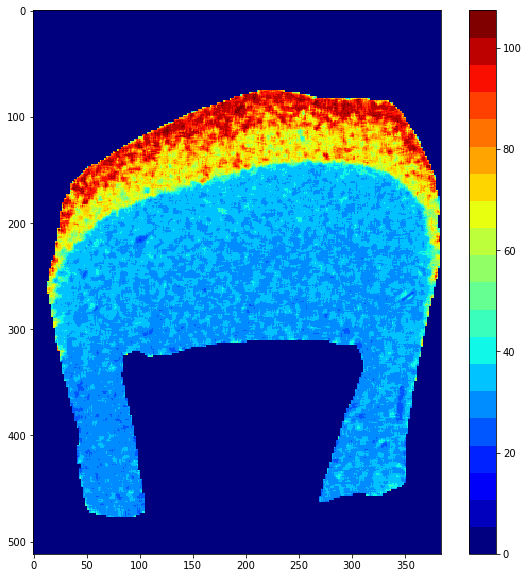

In [135]:
plt.figure(figsize = (10,10))
#plt.imshow(np.mean(pr_array,axis=0), cmap=plt.cm.get_cmap("jet", 20))
#plt.imshow(pred[61], cmap=plt.cm.get_cmap("jet", 20))
plt.imshow(np.mean(pr_array[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
#plt.imshow(np.std(pr_array[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
plt.clim(0, max(Y_E_))
plt.colorbar()

In [182]:
#test_rebuilded_relu, prediction =  predict_all_tooth(AAL_data, comp_keys, Y_H, "./temp-bn-save-relu")

In [ ]:
#np.savetxt('/home/sasha/Documents/molsim/Holger/HNy_prediction_H.txt', rebuilded_new, fmt='1.4f')

In [ ]:
# plt.figure(figsize = (10,10))
# #plt.imshow(np.mean(pr_array,axis=0), cmap=plt.cm.get_cmap("jet", 20))
# #plt.imshow(pred[61], cmap=plt.cm.get_cmap("jet", 20))
# plt.imshow(np.mean(pr_array[np.where(R2_array > 0.8)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
# #plt.imshow(np.std(pr_array[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
# plt.clim(0, max(Y_E_))
# plt.colorbar()
# plt.savefig(save_folder+'mean_pred_AAl_N_20_20colors.png', dpi=300)
# #predictions_jpg_6colors, predictions_jpg_diff_max, predictions_jpg_same_max

In [ ]:
# plt.figure(figsize = (10,10))
# #plt.imshow(np.mean(pr_array,axis=0), cmap=plt.cm.get_cmap("jet", 20))
# #plt.imshow(pred[61], cmap=plt.cm.get_cmap("jet", 20))
# plt.imshow(np.mean(pr_array[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 6))
# #plt.imshow(np.std(pr_array[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
# plt.clim(0, max(Y_H_))
# plt.colorbar()
# plt.savefig(save_folder+'mean_pred_AAl_N_20_6colors.png', dpi=300)
# #predictions_jpg_6colors, predictions_jpg_diff_max, predictions_jpg_same_max

In [ ]:
# plt.figure(figsize = (10,10))
# #plt.imshow(np.mean(pr_array,axis=0), cmap=plt.cm.get_cmap("jet", 20))
# #plt.imshow(pred[61], cmap=plt.cm.get_cmap("jet", 20))
# #plt.imshow(np.mean(pr_array[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
# plt.imshow(np.std(pr_array[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
# #plt.clim(0, max(Y_H_))
# plt.colorbar()
# plt.savefig(save_folder+'std_pred_AAl_N_20_20colors.png', dpi=300)
# #predictions_jpg_6colors, predictions_jpg_diff_max, predictions_jpg_same_max

In [38]:
def save_pred_results(array_pred, N, species_name):
    
    for i in range(len(array_pred)):
        np.savetxt(save_folder+"pred_"+species_name+"/pred_"+str(i)+"_N_"+str(N)+".txt", array_pred[i], fmt='%.7f', delimiter=',')
    
    np.savetxt(save_folder+"mean_pred_"+species_name+"_N_"+str(N)+".txt", np.mean(array_pred[np.where(R2_array > 0.7)[0]],axis=0), fmt='%.7f', delimiter=',')
    np.savetxt(save_folder+"std_pred_"+species_name+"_N_"+str(N)+".txt", np.std(array_pred[np.where(R2_array > 0.7)[0]],axis=0), fmt='%.7f', delimiter=',')
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.mean(array_pred[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
    plt.clim(0, max(Y_E_))
    plt.colorbar()
    plt.savefig(save_folder+'mean_pred_'+species_name+'_N_'+str(N)+'_20colors.png', dpi=300)
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.mean(array_pred[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
    #plt.clim(0, max(Y_H_))
    plt.colorbar()
    plt.savefig(save_folder+'mean_pred_'+species_name+'_N_'+str(N)+'_20colors_nomax.png', dpi=300)
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.mean(array_pred[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 6))
    plt.clim(0, max(Y_E_))
    plt.colorbar()
    plt.savefig(save_folder+'mean_pred_'+species_name+'_N_'+str(N)+'_6colors.png', dpi=300)
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.mean(array_pred[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 6))
    #plt.clim(0, max(Y_H_))
    plt.colorbar()
    plt.savefig(save_folder+'mean_pred_'+species_name+'_N_'+str(N)+'_6colors_nomax.png', dpi=300)
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.std(array_pred[np.where(R2_array > 0.7)[0]],axis=0), cmap=plt.cm.get_cmap("jet", 20))
    plt.colorbar()
    plt.savefig(save_folder+'std_pred_'+species_name+'_N_'+str(N)+'_20colors.png', dpi=300)
    

In [195]:
pred_HCh = []
pred_HIs = []
pred_HNy = []
pred_HSa = []
count = 0
for net1 in nets:
    print(count)
    count += 1
    
    test_rebuilded_new, pr =  predict_all_tooth(HCh_data, comp_keys, Y_E, net1)
    inds = np.where(test_rebuilded_new != 0)
    test_rebuilded_new[inds] = test_rebuilded_new[inds]*var_E + mean_E
    pred_HCh.append(test_rebuilded_new)
    
    test_rebuilded_new, pr =  predict_all_tooth(HIs_data, comp_keys, Y_E, net1)
    inds = np.where(test_rebuilded_new != 0)
    test_rebuilded_new[inds] = test_rebuilded_new[inds]*var_E + mean_E
    pred_HIs.append(test_rebuilded_new)
    
    test_rebuilded_new, pr =  predict_all_tooth(HNy_data, comp_keys, Y_E, net1)
    inds = np.where(test_rebuilded_new != 0)
    test_rebuilded_new[inds] = test_rebuilded_new[inds]*var_E+ mean_E
    pred_HNy.append(test_rebuilded_new)
    
    test_rebuilded_new, pr =  predict_all_tooth(HSa_data, comp_keys, Y_E, net1)
    inds = np.where(test_rebuilded_new != 0)
    test_rebuilded_new[inds] = test_rebuilded_new[inds]*var_E + mean_E
    pred_HSa.append(test_rebuilded_new)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/soft/ANACONDA/Anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/soft/ANACONDA/Anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/soft/ANACONDA/Anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/soft/ANACONDA/Anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/soft/ANACONDA/Anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/soft/ANACONDA/Anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/home/soft/ANACONDA/Anaconda2-5.0.1/lib/python

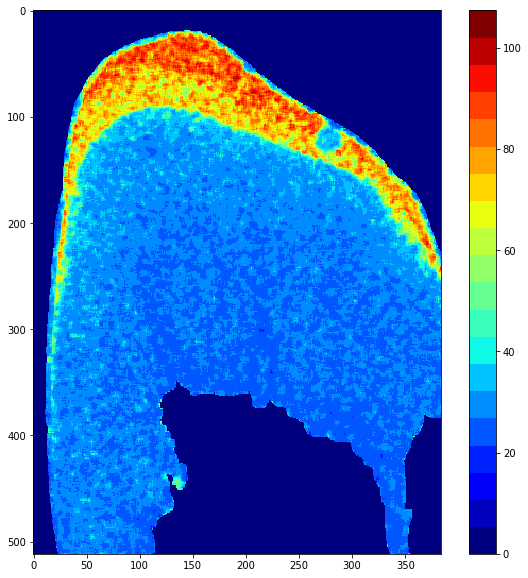

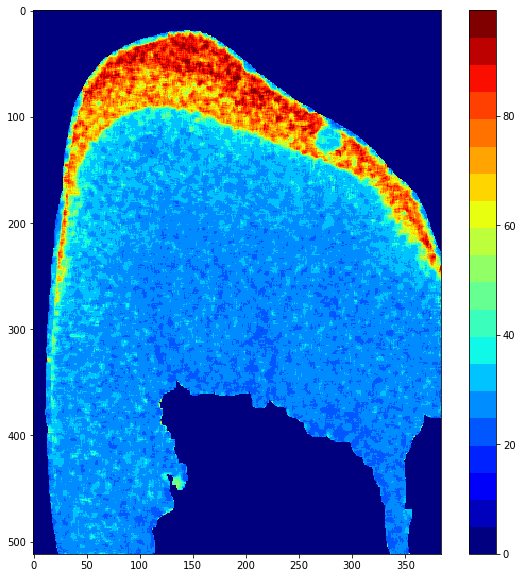

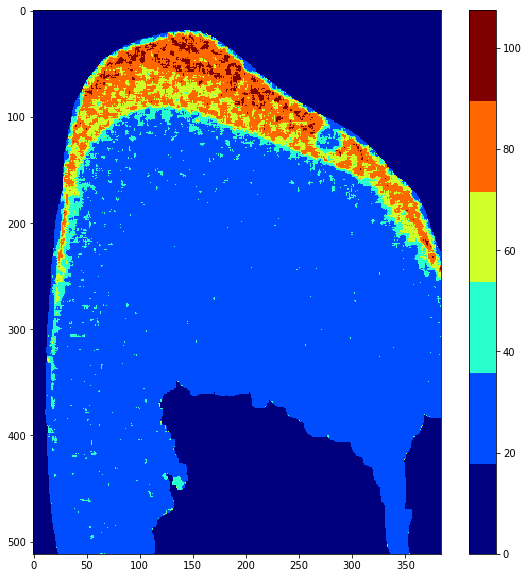

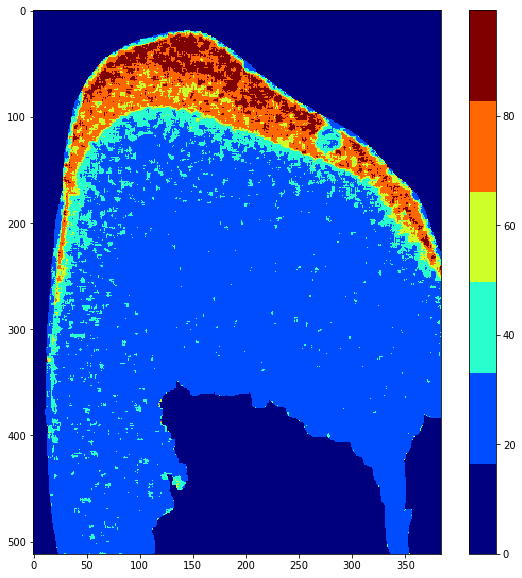

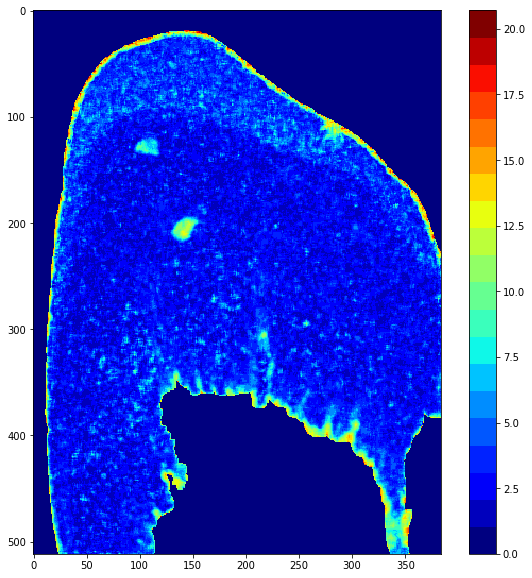

In [200]:
save_pred_results(np.array(pred_HSa), 15, "HSa")

/home/soft/ANACONDA/Anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


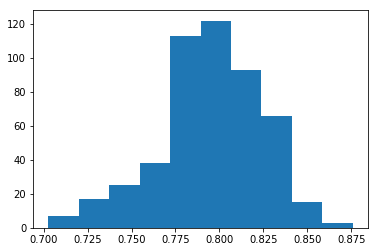

In [197]:
plt.hist(R2_array[np.where(R2_array > 0)[0]])
plt.savefig(save_folder+'R2_distribution_N_15.png', dpi=300)

## Combined R2 and Loss performance

In [3]:
R2_files = []
Loss_files = []
Ns = [5, 8, 10, 12, 15, 18, 20]
for i in Ns:
    tmp = np.genfromtxt(save_folder+'N_'+str(i)+'_R2_Loss.txt', skip_header=1, dtype=float, delimiter=',')
    R2_files.append(tmp[:,0])
    Loss_files.append(tmp[:,1])
R2_all = np.array(R2_files)
Loss_all = np.array(Loss_files)

In [4]:
R2_all[R2_all == -np.inf] = 0.
R2_all[np.isnan(R2_all)]=0.
R2_all[np.where(R2_all < 0) ] = 0.

In [5]:
Loss_all[np.isnan(Loss_all)]=0.3
Loss_all[np.where(Loss_all > 1) ] = 0.3

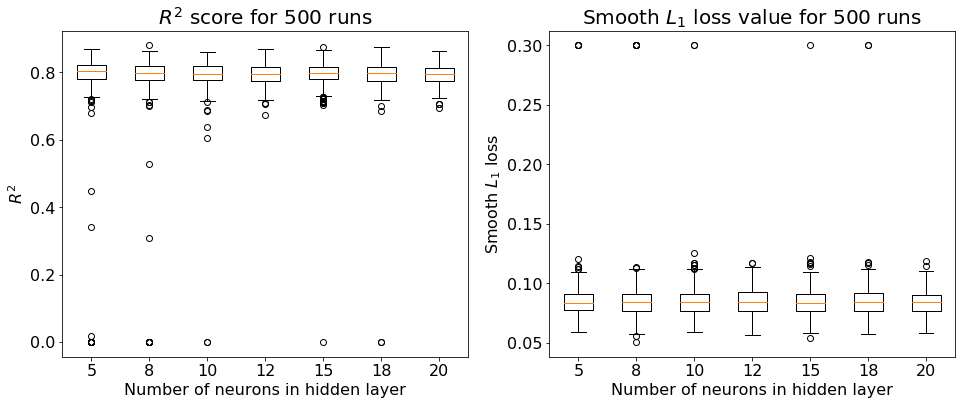

In [8]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.boxplot(R2_all.T)
plt.title(r'$R^2$ score for 500 runs', fontsize=20)
plt.xlabel("Number of neurons in hidden layer", fontsize=16)
plt.ylabel(r'$R^2$', fontsize=16)
plt.xticks(np.arange(len(Ns))+1, Ns, fontsize = 16)
plt.yticks(fontsize = 16)

plt.subplot(122)
plt.boxplot(Loss_all.T)
plt.title(r'Smooth $L_1$ loss value for 500 runs', fontsize=20)
plt.xlabel("Number of neurons in hidden layer", fontsize=16)
plt.ylabel(r'Smooth $L_1$ loss', fontsize=16)
plt.xticks(np.arange(len(Ns))+1, Ns, fontsize = 16)
plt.yticks(fontsize = 16)

plt.savefig(save_folder+'R2_Loss_E.png', dpi=300, bbox_inches = 'tight')
plt.show()

## Importance check

In [9]:
def generate_X_perm(X_orig, data_to_select, feature_ind):
    new_X = np.copy(X_orig)
    #new_X[:,feature_ind] = np.array(random.sample(data_to_select[:,feature_ind], X_orig.shape[0]))
    mu, sigma = np.mean(X_orig[:,feature_ind]), np.std(X_orig[:,feature_ind])
    new_X[:,feature_ind] = np.random.normal(mu, sigma, X_orig.shape[0])
    return new_X

In [10]:
n_neur = 20
#orig_loss = np.genfromtxt(save_folder+'N_'+str(n_neur)+'_R2_Loss.txt', skip_header=1, dtype=float, delimiter=',', usecols=1)
R2_orig = np.genfromtxt(save_folder+'N_'+str(n_neur)+'_R2_Loss.txt', skip_header=1, dtype=float, delimiter=',', usecols=0)

In [11]:
good_NN_inds = np.where(R2_orig > 0.7)[0]

In [12]:
len(good_NN_inds)

499

In [29]:
good_NN_inds = np.where(R2_orig == max(R2_orig))[0]

In [28]:
read_data = []
for c in comp_keys:
    data = np.genfromtxt(HIs_data+"/"+str(c)+".txt" )
    size = data.shape
    #print size

    read_data.append(data.ravel())
read_data = np.array(read_data).T

data_mask = np.zeros(read_data.shape[0])
read_data_new = []
for i in range(len(read_data)):
    if len(np.where(read_data[i] > 0.)[0]) > 3:
        read_data_new.append(read_data[i])
        data_mask[i] = 1

read_data_new = (np.array(read_data_new) - mean_X)/var_X

In [33]:
model = Net(8,n_neur,1)
loss_func = torch.nn.SmoothL1Loss()
KK = 500
LL = len(good_NN_inds) #500

X_train, X_test, y_train, y_test = train_test_split(X, Y_E, test_size=0.20)
y_test= torch.from_numpy(y_test.reshape(y_test.size,1)).float()

all_err_total = np.zeros((LL*KK, 8))
count = 0
for j in good_NN_inds: #range(LL):
    print j
    model.load_state_dict(torch.load(save_folder+'nets/net_'+str(j)+'_N_'+str(n_neur)))
    y_pr = model(torch.from_numpy(X_test).float()) 
    orig_loss = loss_func(y_test, y_pr.detach()).tolist()
    for jj in range(KK):
        all_err1 = np.zeros((X_test.shape[1]))
        for i in range(X_test.shape[1]):
            X_perm = generate_X_perm(X_test, read_data_new, i)
            y_pr = model(torch.from_numpy(X_perm).float())
            #y_pr = y_p.data.numpy()
            all_err1[i] = loss_func(y_test, y_pr.detach()).tolist()
        
        #m = max(all_err1/orig_loss)
        #m_ = min(all_err1/orig_loss)
        all_err_total[count*KK+jj, :] = all_err1/orig_loss#((all_err1/orig_loss) - m_)/(m - m_)
    count += 1

403


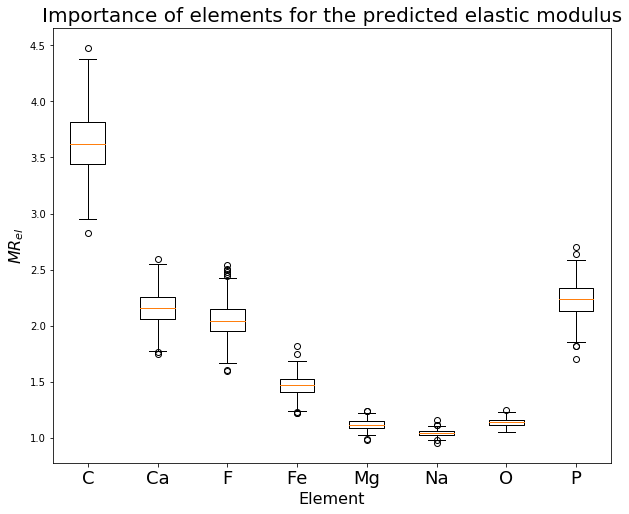

In [37]:
plt.figure(figsize=(10,8))
plt.boxplot(all_err_total)
plt.title("Importance of elements for the predicted elastic modulus", fontsize=20)
plt.xticks(np.arange(len(comp_keys))+1, comp_keys, fontsize=18)
plt.xlabel("Element", fontsize=16)
plt.ylabel(r'$MR_{el}$', fontsize=16)
plt.savefig(save_folder+'importance_1NN_E.png', dpi=300, bbox_inches = 'tight')
plt.show()

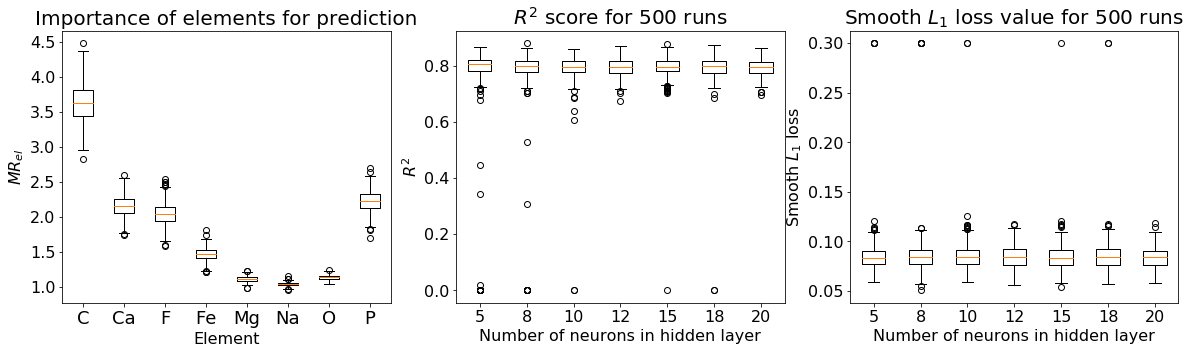

In [45]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.boxplot(all_err_total)
plt.title("Importance of elements for prediction", fontsize=20)
plt.xticks(np.arange(len(comp_keys))+1, comp_keys, fontsize=18)
plt.xlabel("Element", fontsize=16)
plt.yticks(fontsize = 16)
plt.ylabel(r'$MR_{el}$', fontsize=16)

plt.subplot(132)
plt.boxplot(R2_all.T)
plt.title(r'$R^2$ score for 500 runs', fontsize=20)
plt.xlabel("Number of neurons in hidden layer", fontsize=16)
plt.ylabel(r'$R^2$', fontsize=16)
plt.xticks(np.arange(len(Ns))+1, Ns, fontsize = 16)
plt.yticks(fontsize = 16)

plt.subplot(133)
plt.boxplot(Loss_all.T)
plt.title(r'Smooth $L_1$ loss value for 500 runs', fontsize=20)
plt.xlabel("Number of neurons in hidden layer", fontsize=16)
plt.ylabel(r'Smooth $L_1$ loss', fontsize=16)
plt.xticks(np.arange(len(Ns))+1, Ns, fontsize = 16)
plt.yticks(fontsize = 16)

plt.savefig(save_folder+'R2_Loss_Imp_E.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [36]:
np.savetxt(save_folder+'importance_check_1NN_E.txt', all_err_total)

### Plot saved importances

In [42]:
all_err_total_saved = np.genfromtxt(save_folder+'importance_check_1NN_E.txt')

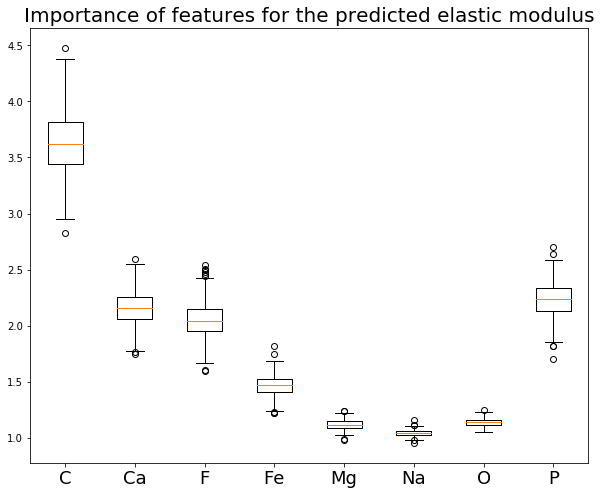

In [43]:
plt.figure(figsize=(10,8))
plt.boxplot(all_err_total_saved)
plt.title("Importance of features for the predicted elastic modulus", fontsize=20)
plt.xticks(np.arange(len(comp_keys))+1, comp_keys, fontsize=18)
#plt.savefig(save_folder+'importance_E.png', dpi=300, bbox_inches = 'tight')
plt.show()

## Make plot of teeth

In [46]:
import matplotlib

In [47]:
save_folder = '/media/sasha/MyBook/oleksandra_home/molsim/Holger/Function Approximation by Neural Network/pytorch_NN/result_E_20190224/'

In [48]:
mean_arr = []
std_arr = []
n_neur = 15
for sp in ["AAl", "HCh", "HIs", "HNy", "HSa"]:
    mean_arr.append(np.genfromtxt(save_folder+"mean_pred_"+sp+"_N_"+str(n_neur)+".txt", delimiter=','))
    std_arr.append(np.genfromtxt(save_folder+"std_pred_"+sp+"_N_"+str(n_neur)+".txt", delimiter=','))

In [49]:
Max_std = np.max(np.array(std_arr))
Max_mean = np.max(np.array(mean_arr))

In [50]:
print Max_mean, np.round(Max_std)

105.8755132 22.0


In [51]:
color_sc_pred = "jet"
color_sc_std = "afmhot_r"

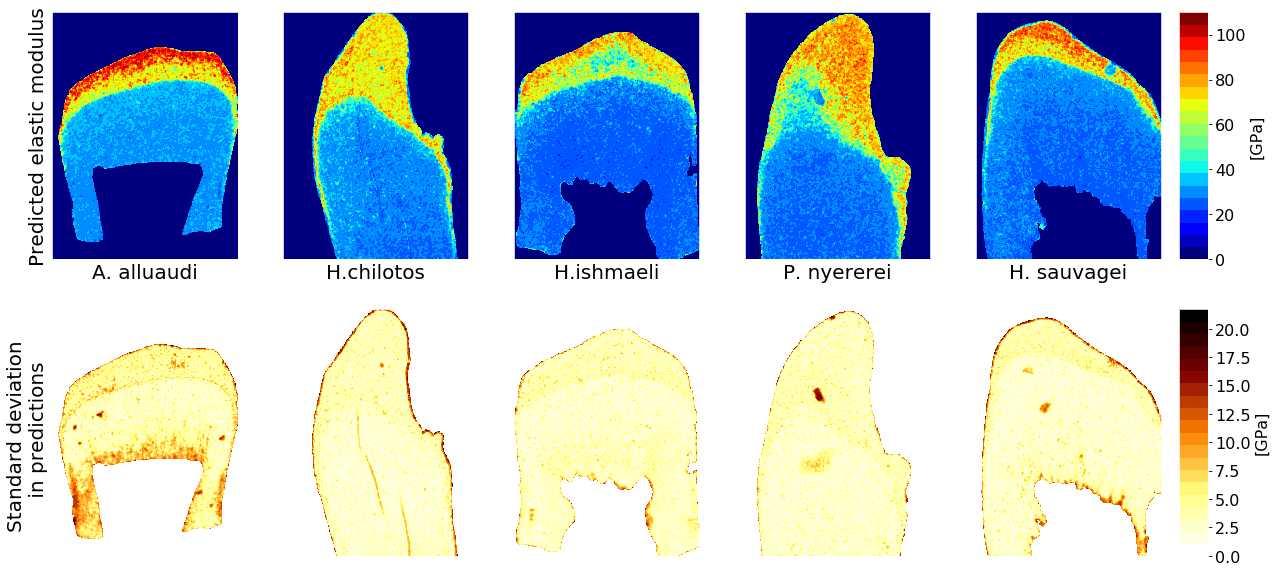

In [53]:
#fig = plt.figure(figsize = (18,10))
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
matplotlib.rc('axes',edgecolor='w')

# AAl
plt.subplot(2,5,1)
plt.imshow(mean_arr[0], cmap=plt.cm.get_cmap(color_sc_pred, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, 110)
plt.xlabel('A. alluaudi', fontsize=20)
plt.ylabel('Predicted elastic modulus', fontsize=20)

plt.subplot(2,5,6)
plt.imshow(std_arr[0], cmap=plt.cm.get_cmap(color_sc_std, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, Max_std)
plt.ylabel('Standard deviation \n in predictions', fontsize=20)

# HCh
plt.subplot(2,5,2)
plt.imshow(mean_arr[1], cmap=plt.cm.get_cmap(color_sc_pred, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, 110)
plt.xlabel('H.chilotos', fontsize=20)

plt.subplot(2,5,7)
plt.imshow(std_arr[1], cmap=plt.cm.get_cmap(color_sc_std, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, Max_std)

# HIs
plt.subplot(2,5,3)
plt.imshow(mean_arr[2], cmap=plt.cm.get_cmap(color_sc_pred, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, 110)
plt.xlabel('H.ishmaeli', fontsize=20)

plt.subplot(2,5,8)
plt.imshow(std_arr[2], cmap=plt.cm.get_cmap(color_sc_std, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, Max_std)

# HNy
plt.subplot(2,5,4)
plt.imshow(mean_arr[3], cmap=plt.cm.get_cmap(color_sc_pred, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, 110)
plt.xlabel('P. nyererei', fontsize=20)

plt.subplot(2,5,9)
plt.imshow(std_arr[3], cmap=plt.cm.get_cmap(color_sc_std, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, Max_std)

# HSa
plt.subplot(2,5,5)
im1 = plt.imshow(mean_arr[4], cmap=plt.cm.get_cmap(color_sc_pred, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, 110)
#plt.colorbar()
plt.xlabel('H. sauvagei', fontsize=20)

plt.subplot(2,5,10)
im2 = plt.imshow(std_arr[4], cmap=plt.cm.get_cmap(color_sc_std, 20))
plt.xticks([])
plt.yticks([])
plt.clim(0, Max_std)
#plt.colorbar()


cax = plt.axes([0.91, 0.537, 0.02, 0.343])
cbar = plt.colorbar(im1, cax=cax)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(r"[GPa]", size=16)

cax = plt.axes([0.91, 0.125, 0.02, 0.343])
cbar = plt.colorbar(im2, cax=cax)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(r"[GPa]", size=16)


plt.savefig(save_folder+'all_E.png', dpi=300, bbox_inches = 'tight')
plt.show()